#Generated Adversarial Image

*References:
[https://medium.com/@ageitgey/machine-learning-is-fun-part-8-how-to-intentionally-trick-neural-networks-b55da32b7196](https://medium.com/@ageitgey/machine-learning-is-fun-part-8-how-to-intentionally-trick-neural-networks-b55da32b7196)
[https://github.com/jpatrickpark/neural_net_tutorial/blob/master/generated_adversarial_image.py](https://github.com/jpatrickpark/neural_net_tutorial/blob/master/generated_adversarial_image.py)


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/learning-stack/Colab-ML-Playbook/blob/master/Generated%20Adversarial%20Image/Keras_examples_MNIST_CNN.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/learning-stack/Colab-ML-Playbook/blob/master/Generated%20Adversarial%20Image/Keras_examples_MNIST_CNN.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

In [1]:
! pip3 install keras

In [2]:
import numpy as np
from keras.preprocessing import image
from keras.applications import inception_v3
from keras import backend as K
from PIL import Image

Using TensorFlow backend.


In [3]:
# Load pre-trained image recognition model
model = inception_v3.InceptionV3()

96116736/96112376 [==============================] - 18s 0us/step


In [0]:
# Grab a reference to the first and last layer of the neural net
model_input_layer = model.layers[0].input
model_output_layer = model.layers[-1].output

In [0]:
# Choose an ImageNet object to fake
# The list of classes is available here: https://gist.github.com/ageitgey/4e1342c10a71981d0b491e1b8227328b
# Class #859 is "toaster"
object_type_to_fake = 859

In [7]:
# Get the persian cat image

!wget https://cdn-images-1.medium.com/max/1600/1*xNGCocsmmxysEr1kuxgjCA.png


--2018-08-24 21:39:51--  https://cdn-images-1.medium.com/max/1600/1*xNGCocsmmxysEr1kuxgjCA.png
Resolving cdn-images-1.medium.com (cdn-images-1.medium.com)... 104.16.121.145, 104.16.117.145, 104.16.120.145, ...
Connecting to cdn-images-1.medium.com (cdn-images-1.medium.com)|104.16.121.145|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 130248 (127K) [image/png]
Saving to: ‘1*xNGCocsmmxysEr1kuxgjCA.png’

1*xNGCocsmmxysEr1ku 100%[===================>] 127.20K  --.-KB/s    in 0.02s   

2018-08-24 21:39:52 (8.00 MB/s) - ‘1*xNGCocsmmxysEr1kuxgjCA.png’ saved [130248/130248]



FileNotFoundError: ignored

In [0]:
# Load the image to hack
img = image.load_img("1*xNGCocsmmxysEr1kuxgjCA.png", target_size=(299, 299))
original_image = image.img_to_array(img)

In [0]:
# Scale the image so all pixel intensities are between [-1, 1] as the model expects
original_image /= 255.
original_image -= 0.5
original_image *= 2.

In [0]:
# Add a 4th dimension for batch size (as Keras expects)
original_image = np.expand_dims(original_image, axis=0)

In [0]:
# Pre-calculate the maximum change we will allow to the image
# We'll make sure our hacked image never goes past this so it doesn't look funny.
# A larger number produces an image faster but risks more distortion.
max_change_above = original_image + 0.01
max_change_below = original_image - 0.01

In [0]:
# Create a copy of the input image to hack on
hacked_image = np.copy(original_image)

In [0]:
# How much to update the hacked image in each iteration
learning_rate = 0.1

In [0]:
# Define the cost function.
# Our 'cost' will be the likelihood out image is the target class according to the pre-trained model
cost_function = model_output_layer[0, object_type_to_fake]

In [0]:
# We'll ask Keras to calculate the gradient based on the input image and the currently predicted class
# In this case, referring to "model_input_layer" will give us back image we are hacking.
gradient_function = K.gradients(cost_function, model_input_layer)[0]

In [0]:
# Create a Keras function that we can call to calculate the current cost and gradient
grab_cost_and_gradients_from_model = K.function([model_input_layer, K.learning_phase()], [cost_function, gradient_function])

cost = 0.0

In [18]:
# In a loop, keep adjusting the hacked image slightly so that it tricks the model more and more
# until it gets to at least 80% confidence
while cost < 0.80:
    # Check how close the image is to our target class and grab the gradients we
    # can use to push it one more step in that direction.
    # Note: It's really important to pass in '0' for the Keras learning mode here!
    # Keras layers behave differently in prediction vs. train modes!
    cost, gradients = grab_cost_and_gradients_from_model([hacked_image, 0])

    # Move the hacked image one step further towards fooling the model
    hacked_image += gradients * learning_rate

    # Ensure that the image doesn't ever change too much to either look funny or to become an invalid image
    hacked_image = np.clip(hacked_image, max_change_below, max_change_above)
    hacked_image = np.clip(hacked_image, -1.0, 1.0)
    

    print("Model's predicted likelihood that the image is a toaster: {:.8}%".format(cost * 100))


Model's predicted likelihood that the image is a toaster: 98.089534%


In [0]:
# De-scale the image's pixels from [-1, 1] back to the [0, 255] range
img = hacked_image[0]
img /= 2.
img += 0.5
img *= 255.

In [0]:
# Save the hacked image!
im = Image.fromarray(img.astype(np.uint8))
im.save("hacked-image.png")

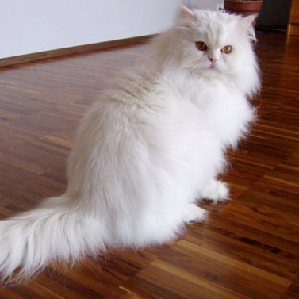

In [21]:
from IPython.display import Image
Image('hacked-image.png')